# Project 4 - Portuguese Bank Marketing 

The purpose of this project is to use the available data to find new customers. The models I create will be used by the bank to choose how to target potential customers. 

**Dataset** The dataset includes 17 variables related to a direct marketing campaign of a Portuguese banking institution. The attributes include variables such as age, job, marital status, education, etc. Your goal is to predict if an individual will become a customer. 

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
from sklearn import feature_selection as fs
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm


%matplotlib inline

In [31]:
bank_data = pd.read_csv('./bank/bank-full.csv', sep=';')

print(bank_data.shape)
bank_data.head(20)

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [8]:
# Many columns have 'unknown' 
(bank_data.astype(np.object) == 'unknown').any()

age          False
job           True
marital      False
education     True
default      False
balance      False
housing      False
loan         False
contact       True
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome      True
y            False
dtype: bool

In [19]:
# Separating columns by column type for later use
bin_cols = ['housing', 'loan', 'default']
num_cols = ['age','duration','balance','previous','pdays']
cat_cols = ['marital','education','contact','poutcome'] + bin_cols

bank_data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [3]:
for col in bank_data.columns:
    if bank_data[col].dtype == object:
        count = 0
        count = [count + 1 for x in bank_data[col] if x == 'unknown']
        print(col + ' ' + str(sum(count)))

job 288
marital 0
education 1857
default 0
housing 0
loan 0
contact 13020
month 0
poutcome 36959
y 0


In [4]:
# Way more unknown than known - column might be dropped
print(bank_data[['poutcome','age']].groupby('poutcome').count())

# bank_data.drop(labels='poutcome', axis=1, inplace=True)

            age
poutcome       
failure    4901
other      1840
success    1511
unknown   36959


In [5]:
# Contact communication type - probably won't be useful
"""COME BACK TO"""
print(bank_data[['contact','age']].groupby('contact').count())

             age
contact         
cellular   29285
telephone   2906
unknown    13020


/Users/anniesiddle/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


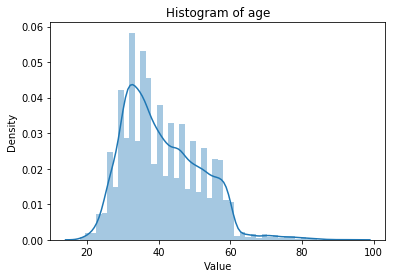

In [6]:
def hist_plot(vals, lab):
    ## Distribution plot of values
    sns.distplot(vals)
    plt.title('Histogram of ' + lab)
    plt.xlabel('Value')
    plt.ylabel('Density')

cols = ['age', 'balance', 'duration', 'campaign', 'pdays']
hist_plot(bank_data['age'], 'age')

/Users/anniesiddle/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


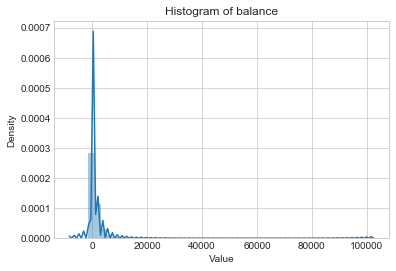

In [32]:
# Balance has some huge outliers
hist_plot(bank_data['balance'], 'balance')

/Users/anniesiddle/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


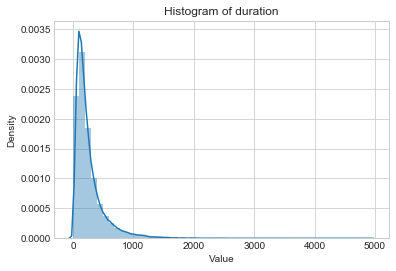

In [34]:
hist_plot(bank_data['duration'], 'duration')

/Users/anniesiddle/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


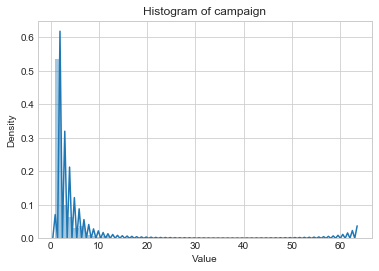

In [35]:
hist_plot(bank_data['campaign'], 'campaign')

/Users/anniesiddle/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Numner of -1s:  36954
Numner of 999:  0


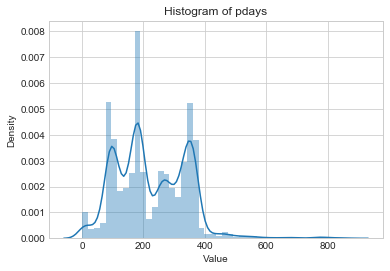

In [48]:
# A lot have never been contacted
hist_plot(bank_data[bank_data['pdays'] != -1]['pdays'], 'pdays')

# Documentation said 999 was for never - probably actually -1
print('Numner of -1s: ', bank_data[bank_data['pdays'] == -1].shape[0])
print('Numner of 999: ', bank_data[bank_data['pdays'] == 999].shape[0])

In [9]:
print(bank_data[['job','y']].groupby('job').count())

                age
job                
admin.         5171
blue-collar    9732
entrepreneur   1487
housemaid      1240
management     9458
retired        2264
self-employed  1579
services       4154
student         938
technician     7597
unemployed     1303
unknown         288


In [21]:
print(bank_data[['marital','y']].groupby('marital').count())

              y
marital        
divorced   5207
married   27214
single    12790


In [22]:
print(bank_data[['education','y']].groupby('education').count())

               y
education       
primary     6851
secondary  23202
tertiary   13301
unknown     1857


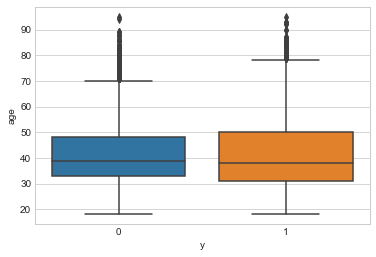

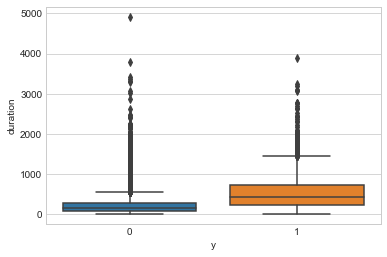

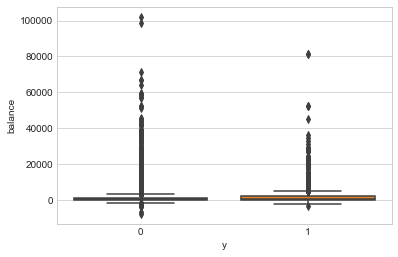

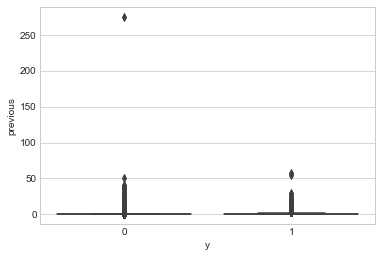

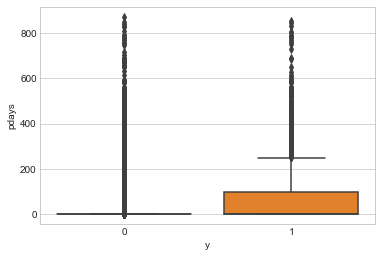

In [24]:
# Visualizing for numeric columns
def plot_box(bank_data, cols, col_x = 'y'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.boxplot(col_x, col, data=bank_data)
        plt.xlabel(col_x) # Set text for the x axis
        plt.ylabel(col)# Set text for y axis
        plt.show()

num_cols = ['age','duration','balance','previous','pdays']
plot_box(bank_data, num_cols)

marital


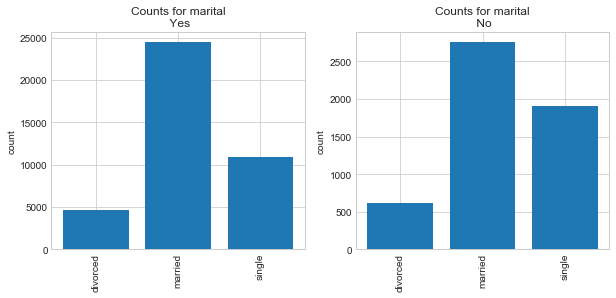

education


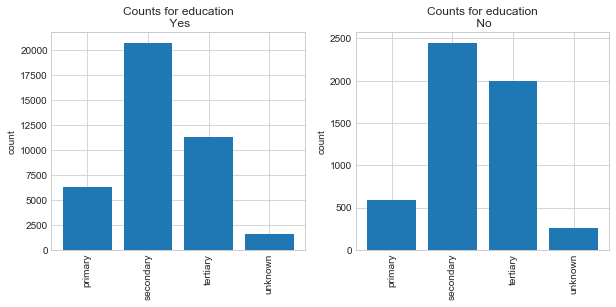

contact


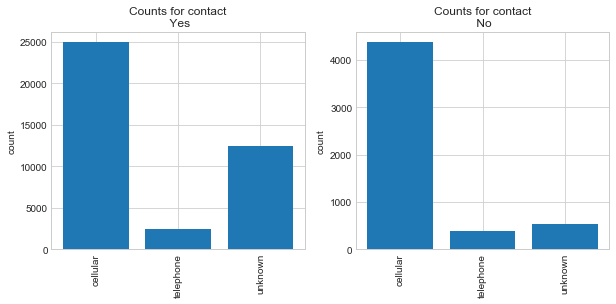

day


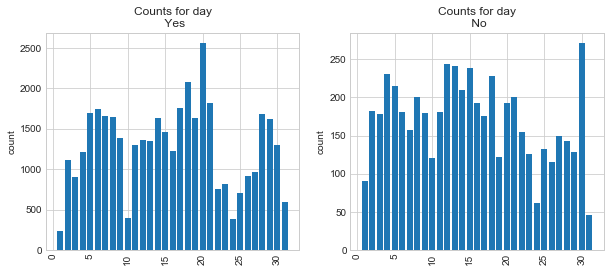

month


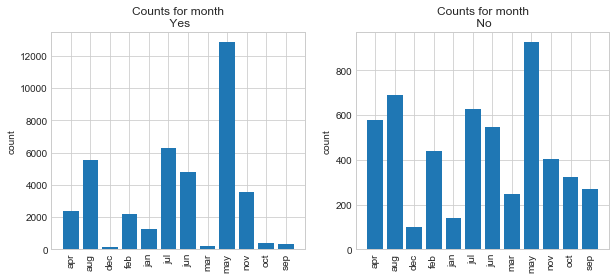

poutcome


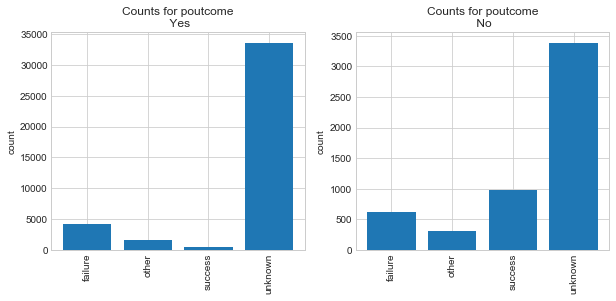

y


ValueError: Grouper for 'y' not 1-dimensional

In [30]:
# Visualizing Categorical Columns 
bank_data['dummy'] = np.ones(shape = bank_data.shape[0])
for col in cat_cols:
    print(col)
    counts = bank_data[['dummy', 'y', col]].groupby(['y', col], as_index = False).count()
    temp = counts[counts['y'] == 0][[col, 'dummy']]
    _ = plt.figure(figsize = (10,4))
    plt.subplot(1, 2, 1)
    temp = counts[counts['y'] == 0][[col, 'dummy']]
    plt.bar(temp[col], temp.dummy)
    plt.xticks(rotation=90)
    plt.title('Counts for ' + col + '\n No')
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    temp = counts[counts['y'] == 1][[col, 'dummy']]
    plt.bar(temp[col], temp.dummy)
    plt.xticks(rotation=90)
    plt.title('Counts for ' + col + '\n Yes')
    plt.ylabel('count')
    plt.show()

                age
month result       
apr   0        2355
      1         577
aug   0        5559
      1         688
dec   0         114
      1         100
feb   0        2208
      1         441
jan   0        1261
      1         142
jul   0        6268
      1         627
jun   0        4795
      1         546
mar   0         229
      1         248
may   0       12841
      1         925
nov   0        3567
      1         403
oct   0         415
      1         323
sep   0         310
      1         269


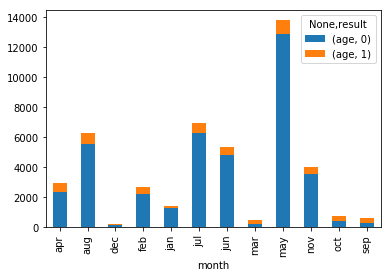

In [15]:
month_group = bank_data[['month','result','age']].groupby(['month','result']).count()
month_group.unstack().plot(kind='bar', stacked=True)

## Manipulating Data
Making all columns numerical, one-hotting categorical variables, scaling

In [9]:
# need to encode categorical variables and one hot them

In [32]:
# Changing yes and no to 0 or 1 (1=yes)
# 1 means they became a customer
bank_data['y'] = [1 if x == 'yes' else 0 for x in bank_data['y']]

bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [33]:
# Converting all categorical columns into dummy variables
cat_cols = ['marital','education','contact','poutcome','housing', 'loan', 'default', 'month']

def encode_string(cat_features):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

Features = encode_string(bank_data[cat_cols[0]])
for col in cat_cols[1:]:
    temp = encode_string(bank_data[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])  

(45211, 32)
[[0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]]


In [34]:
# Adding the numerical variables
num_cols = ['age','duration','balance','previous','pdays']
Features = np.concatenate([Features, np.array(bank_data[num_cols])], axis = 1)
print(Features.shape)
print(Features[:2, :])   

(45211, 37)
[[ 0.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00  1.000e+00
   0.000e+00  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  1.000e+00  0.000e+00  1.000e+00  1.000e+00  0.000e+00
   1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.000e+00  0.000e+00
   0.000e+00  0.000e+00  5.800e+01  2.610e+02  2.143e+03  0.000e+00
  -1.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00  1.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  1.000e+00  0.000e+00  1.000e+00  1.000e+00  0.000e+00
   1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.000e+00  0.000e+00
   0.000e+00  0.000e+00  4.400e+01  1.510e+02  2.900e+01  0.000e+00
  -1.000e+00]]


## Spliting data into training group and test group

In [35]:
# Labels
labels = np.array(bank_data['y'])

In [36]:
# Randomly sample cases to create independent training and test data
nr.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 500)
X_train = Features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

In [37]:
# Scaling my train and test data
scaler = preprocessing.StandardScaler().fit(X_train[:,34:])
X_train[:,34:] = scaler.transform(X_train[:,34:])
X_test[:,34:] = scaler.transform(X_test[:,34:])
X_train[:2,]

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.00000000e+01,
         1.42000000e+02,  8.36097121e-02, -2.51691630e-01,
        -4.11298769e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00

# Classification Model
Classification through Logistic Regression

In [38]:
# No weighting for first try
logistic_mod = linear_model.LogisticRegression() 
logistic_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
print(logistic_mod.intercept_)
print(logistic_mod.coef_)

[-0.83665087]
[[-0.25534094 -0.46486785 -0.11644208 -0.45539993 -0.20416217 -0.05332673
  -0.12376205  0.31757005  0.16935045 -1.32357137 -0.80332404 -0.59003311
   1.49774987 -0.9410436  -0.05337544 -0.78327543 -0.183263   -0.65338787
  -0.41919768 -0.41745319 -0.05474249 -0.92475544  0.43020064 -0.34342159
  -1.12744138 -0.99491385  0.28231902  1.52927517 -0.49789653 -0.94620632
   0.96087887  0.85005303  0.00300673  0.00416514  0.04015581  0.01710984
  -0.02108215]]


In [40]:
# Most seem to predict 0
probabilities = logistic_mod.predict_proba(X_test)
print(probabilities[:10,:])

[[0.94975453 0.05024547]
 [0.01675728 0.98324272]
 [0.9435672  0.0564328 ]
 [0.97605788 0.02394212]
 [0.99315735 0.00684265]
 [0.95535167 0.04464833]
 [0.20229839 0.79770161]
 [0.97231137 0.02768863]
 [0.01443775 0.98556225]
 [0.94047278 0.05952722]]


In [41]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)
print('Prediction: ', np.array(scores[:25]))
print('    Actual: ', y_test[:25])

# 0 means Not a customer
# 1 means Customer

Prediction:  [0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    Actual:  [0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [42]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])
    print('')
    print('Reference: Negative means "become a customer"')


    
print_metrics(y_test, scores)  

                 Confusion matrix
                 Score positive    Score negative
Actual positive       422                15
Actual negative        44                19

Accuracy  0.88
 
           Positive      Negative
Num case      437            63
Precision    0.91          0.56
Recall       0.97          0.30
F1           0.93          0.39

Reference: Negative means "become a customer"


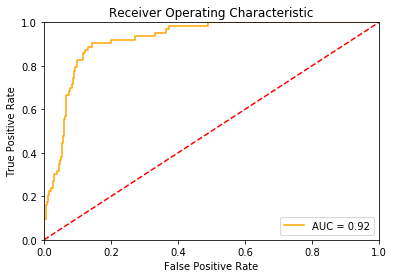

In [43]:
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, probabilities)  

## Second Classification Model
Dealing with the class imbalance: 88% of the data has a is positive, so it will be overweighted

In [44]:
# Data is unbalanced, will be biased towards 0 
counts = bank_data.groupby('y').count()
counts['percent'] = counts['age'] / bank_data.shape[0] * 100
counts['percent'] 

y
0    88.30152
1    11.69848
Name: percent, dtype: float64

In [45]:
# Choosing 40% / 60% split for first test
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.4, 1:0.6}) 
logistic_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 0.4, 1: 0.6}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [46]:
probabilities = logistic_mod.predict_proba(X_test)
scores = score_model(probabilities, 0.5)
print_metrics(y_test, scores)  

                 Confusion matrix
                 Score positive    Score negative
Actual positive       414                23
Actual negative        39                24

Accuracy  0.88
 
           Positive      Negative
Num case      437            63
Precision    0.91          0.51
Recall       0.95          0.38
F1           0.93          0.44

Reference: Negative means "become a customer"


In [47]:
# Choosing 20% / 80% split for first test
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.2, 1:0.8}) 
logistic_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 0.2, 1: 0.8}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [48]:
probabilities = logistic_mod.predict_proba(X_test)
scores = score_model(probabilities, 0.5)
print_metrics(y_test, scores)  

                 Confusion matrix
                 Score positive    Score negative
Actual positive       401                36
Actual negative        20                43

Accuracy  0.89
 
           Positive      Negative
Num case      437            63
Precision    0.95          0.54
Recall       0.92          0.68
F1           0.93          0.61

Reference: Negative means "become a customer"


### Comparing the Unweighted and Weighted Models
- Accuracy is consistent
- Unwieghted has more False positives
- 80%/20% Split has lowest false positives, but highest false negatives
- 80%/20% Split has highest precision (94% compared to 90% and 89% for positive)
- Biggest difference is in guessing negatives correctly - In this context correctly guessing negative means correclty identifying who will become a customer
    - 80%/20% Split has 26 true negatives
    - 60%/40% Split has 15
    - Unweighted has 13 
    
  
** I would choose the weighted model because I would optimize the new customers I can find. **

## Testing Feature Selection

In [49]:
# Feature Selection
print(Features.shape)

## Define the variance threhold and fit the threshold to the feature array. 
sel = fs.VarianceThreshold(threshold=(.8 * (1 - .8)))
Features_reduced = sel.fit_transform(Features)

## Print the support and shape for the transformed features
print(sel.get_support())
print(Features_reduced.shape)

(45211, 37)
[False  True  True False  True  True False  True False  True False False
 False False  True  True False False False False False False False False
 False False False False  True False False False  True  True  True  True
  True]
(45211, 14)


In [60]:
# Creating a new model with reduced features
print('Current Number of Features: ', Features_reduced.shape[1])
print(' ')

# Randomly sample cases to create independent training and test data
nr.seed(9988)
indx = range(Features_reduced.shape[0])
indx = ms.train_test_split(indx, test_size = 500)
X_train = Features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

# Scaling my train and test data
scaler = preprocessing.StandardScaler().fit(X_train[:,19:])
X_train[:,19:] = scaler.transform(X_train[:,19:])
X_test[:,19:] = scaler.transform(X_test[:,19:])
# X_train[:,:] = scaler.transform(X_train[:,:])
# X_test[:,:] = scaler.transform(X_test[:,:])

# Training a new model
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.2, 1:0.8}) 
logistic_mod.fit(X_train, y_train)

# Evaluate the model
probabilities = logistic_mod.predict_proba(X_test)
scores = score_model(probabilities, 0.5)
print_metrics(y_test, scores)  



Current Number of Features:  14
 
                 Confusion matrix
                 Score positive    Score negative
Actual positive       401                36
Actual negative        20                43

Accuracy  0.89
 
           Positive      Negative
Num case      437            63
Precision    0.95          0.54
Recall       0.92          0.68
F1           0.93          0.61

Reference: Negative means "become a customer"


### Notes on Feature Selection 
No change in metrics with only 14 features, instead of 37.

Smaller number of features means a less complex model, which should generalize better.

## Updating Probabality Threshold
A lower probability threshold will bias towards finding all potential customers.

In [61]:
# Do I want the probability threshold to be lower - to find more potential customers?

scores = score_model(probabilities, 0.3)
print_metrics(y_test, scores)  

                 Confusion matrix
                 Score positive    Score negative
Actual positive       381                56
Actual negative         9                54

Accuracy  0.87
 
           Positive      Negative
Num case      437            63
Precision    0.98          0.49
Recall       0.87          0.86
F1           0.92          0.62

Reference: Negative means "become a customer"


### Effects of a Lower Probability Threshold
- Higher recall - more new customers are found
- Lower precision for Negative cases - more false negatives
- Higher precision for Positives - few false positives
- Accuracy is slightly lower

** Lower Probability threshold means we are increasing our chances of finding new customers. **

## Cross Validation


In [52]:
Labels = labels.reshape(labels.shape[0],)
scoring = ['precision_macro', 'recall_macro', 'roc_auc']
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.2, 1:0.8}) 
scores = ms.cross_validate(logistic_mod, Features, Labels, scoring=scoring,
                        cv=10, return_train_score=False)

In [53]:
def print_format(f,x,y,z):
    print('Fold %2d    %4.3f        %4.3f      %4.3f' % (f, x, y, z))

def print_cv(scores):
    fold = [x + 1 for x in range(len(scores['test_precision_macro']))]
    print('         Precision     Recall       AUC')
    [print_format(f,x,y,z) for f,x,y,z in zip(fold, scores['test_precision_macro'], 
                                          scores['test_recall_macro'],
                                          scores['test_roc_auc'])]
    print('-' * 40)
    print('Mean       %4.3f        %4.3f      %4.3f' % 
          (np.mean(scores['test_precision_macro']), np.mean(scores['test_recall_macro']), np.mean(scores['test_roc_auc'])))  
    print('Std        %4.3f        %4.3f      %4.3f' % 
          (np.std(scores['test_precision_macro']), np.std(scores['test_recall_macro']), np.std(scores['test_roc_auc'])))

print_cv(scores)   

         Precision     Recall       AUC
Fold  1    0.890        0.639      0.969
Fold  2    0.888        0.827      0.973
Fold  3    0.617        0.698      0.729
Fold  4    0.584        0.612      0.689
Fold  5    0.720        0.767      0.882
Fold  6    0.629        0.637      0.710
Fold  7    0.553        0.614      0.632
Fold  8    0.440        0.380      0.329
Fold  9    0.672        0.812      0.871
Fold 10    0.574        0.679      0.768
----------------------------------------
Mean       0.657        0.667      0.755
Std        0.136        0.121      0.181


---------------------------

# Random Forest Model
Creating multiple decision tree models and aggregating together for best results

In [54]:
# Features and lables
Labels = labels.reshape(labels.shape[0],)
print(Features.shape)
print(Labels.shape)

(45211, 37)
(45211,)


In [55]:
# Using Cross validation to estimate hyper parameters
nr.seed(123)
inside = ms.KFold(n_splits=10, shuffle = True)
nr.seed(321)
outside = ms.KFold(n_splits=10, shuffle = True)

In [13]:
## Define the dictionary for the grid search and the model object to search on
param_grid = {"max_features": [2, 3, 5, 10, 15, 20], "min_samples_leaf":[3, 5, 10, 20]}
## Define the random forest model
nr.seed(3456)
rf_clf = RandomForestClassifier(class_weight = "balanced") # class_weight = {0:0.33, 1:0.67}) 

## Perform the grid search over the parameters
nr.seed(4455)
rf_clf = ms.GridSearchCV(estimator = rf_clf, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'roc_auc',
                      return_train_score = True)
rf_clf.fit(Features, Labels)
print(rf_clf.best_estimator_.max_features)
print(rf_clf.best_estimator_.min_samples_leaf)

15
20


In [14]:
# Outer cross validation
# Metric choosen is ROC_AUC
nr.seed(498)
cv_estimate = ms.cross_val_score(rf_clf, Features, Labels, 
                                 cv = outside) # Use the outside folds

print('Mean performance metric = %4.3f' % np.mean(cv_estimate))
print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean performance metric = 0.919
SDT of the metric       = 0.005
Outcomes by cv fold
Fold  1    0.919
Fold  2    0.914
Fold  3    0.921
Fold  4    0.918
Fold  5    0.929
Fold  6    0.914
Fold  7    0.918
Fold  8    0.914
Fold  9    0.919
Fold 10    0.928


In [56]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 500)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

In [57]:
# Creating the Random Forest Classifier using hyper parameters found above
nr.seed(1115)
rf_mod = RandomForestClassifier(class_weight = "balanced", 
                                max_features = rf_clf.best_estimator_.max_features, 
                                min_samples_leaf = rf_clf.best_estimator_.min_samples_leaf) 
rf_mod.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=15,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [58]:
# Scoring the model
probabilities = rf_mod.predict_proba(X_test)
scores = score_model(probabilities, 0.5)
print_metrics(y_test, scores)

                 Confusion matrix
                 Score positive    Score negative
Actual positive       379                68
Actual negative         6                47

Accuracy  0.85
 
           Positive      Negative
Num case      447            53
Precision    0.98          0.41
Recall       0.85          0.89
F1           0.91          0.56

Reference: Negative means "become a customer"


In [59]:
scores = score_model(probabilities, 0.3)
print_metrics(y_test, scores)

                 Confusion matrix
                 Score positive    Score negative
Actual positive       325               122
Actual negative         2                51

Accuracy  0.75
 
           Positive      Negative
Num case      447            53
Precision    0.99          0.29
Recall       0.73          0.96
F1           0.84          0.45

Reference: Negative means "become a customer"


## Random Forest Model Analysis
- Using 0.5 as the probability threshold has higher accuracy
- Recall for negative cases is high - we wouldn't miss anyone who would become a customer
- Precision is low for negative cases
- More False negatives for lower threshold

I would choose 0.5 for the probabalility threshold in this case.


-------

## Analysis

I chose to do classification with a linear regression model and a random forest model. For both models, I had to create dummy variables by one-hotting for the categorical variables. I also scaled the numerical variables to avoid biasing the model towards variables with higher magnitudes. 

For the linear regression model, I tested weighted and unweighted data, since the data has an unbalanced number of positive and negative cases. I also used feature selection to reduce the number of variables so that the model will generalize better. I also update the probability threshold to bais towards finding negative cases, because negative cases are more useful to the business for this question.

For the random forest model, I tested mulitple hyperparameters to find the optimized cases for this data. I then used those hyperparameters to test the model. I also looked at updating the probability threshold for this model, but found that it was not needed. 

Overall, I would choose the linear regression model as my final model. The accuracy was 87%. I was also able to maximize the number of true negatives found, which means the bank would increase its chances of finding new customers. 